# Bayesian Neural Network development notebook

This notebook is to prototype and develop a BNN to classify SAGE sources

In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pandas as pd
import pytensor
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

In [2]:
floatX = pytensor.config.floatX
RANDOM_SEED = 9927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

Load some data

In [3]:
file = Path("../../data/Labeled_SAGE_Final.csv")
df = pd.read_csv(file)
print(len(df))
df.head()

705


,universalID,matchType,MCPSID,TmassCntr,IracID,MipsID,IRSFID,OGLEID,IracDesignation,MipsDesignation,...,Yap3,e_Yap3,Yrms,Yell,YPA,Yperrbits,flgVar,prim,angDist_Vist,Jones_Spec_Label
0,302,iracid+mipsid+mcpsid+irsfid+ogleid,101889476.0,5.134960e+07,1.536390e+09,1.529269e+09,1.000274e+09,1.616997e+09,SSTISAGEMA J044458.39-703522.6,SSTM1SAGE1 J044458.41-703522.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OPAGB
1,343,iracid+mipsid+mcpsid+irsfid+ogleid,102024041.0,0.000000e+00,1.536442e+09,1.529270e+09,1.000413e+09,1.616586e+09,SSTISAGEMA J044627.10-684747.0,SSTM1SAGE1 J044627.07-684746.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CAGB
2,1056,iracid+mipsid+mcpsid+irsfid,115769476.0,1.218455e+09,1.536474e+09,1.529271e+09,1.000507e+09,NaN,SSTISAGEMA J044718.63-694220.6,SSTM1SAGE1 J044718.61-694220.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RSG
3,1129,iracid+mipsid+mcpsid+irsfid+ogleid,102229713.0,1.218475e+09,1.536527e+09,1.529266e+09,1.000664e+09,1.616669e+09,SSTISAGEMA J044837.77-692337.0,SSTM1SAGE1 J044837.71-692336.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,YSO2
4,1147,iracid+mipsid+mcpsid+irsfid+ogleid,114855028.0,1.218449e+09,1.536472e+09,1.529266e+09,1.000503e+09,1.616547e+09,SSTISAGEMA J044716.09-682425.7,SSTM1SAGE1 J044716.10-682425.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CAGB


In [4]:
for col in df.columns:
    # print(col, df[col].dtype)
    print(f"Column {col} (dtype: {df[col].dtype}) has {df[col].isnull().sum()} missing values")

Column universalID (dtype: int64) has 0 missing values
Column matchType (dtype: object) has 0 missing values
Column MCPSID (dtype: float64) has 296 missing values
Column TmassCntr (dtype: float64) has 0 missing values
Column IracID (dtype: float64) has 0 missing values
Column MipsID (dtype: float64) has 85 missing values
Column IRSFID (dtype: float64) has 58 missing values
Column OGLEID (dtype: float64) has 317 missing values
Column IracDesignation (dtype: object) has 0 missing values
Column MipsDesignation (dtype: object) has 85 missing values
Column IracEpoch (dtype: object) has 0 missing values
Column MipsEpoch (dtype: object) has 85 missing values
Column IracMCPSDist (dtype: float64) has 296 missing values
Column IracMCPSDistRank (dtype: float64) has 296 missing values
Column MipsMCPSDist (dtype: float64) has 339 missing values
Column MipsMCPSDistRank (dtype: float64) has 339 missing values
Column IracMipsDist (dtype: float64) has 85 missing values
Column IracMipsDistRank (dtype: f

In [5]:
dev_col_subset = ["RA", "Dec", "magB", "magV", "magK", "mag3_6", "mag4_5", "mag5_8", "mag8_0", "mag24", "parallax", "pmra", "pmdec"]
dev_col_subset_uncs = ["dra", "ddec", "dmagB", "dmagV", "dmagK", "dmag3_6", "dmag4_5", "dmag5_8", "dmag8_0", "dmag24", "parallax_error", "pmra_error", "pmdec_error"]
target_col = "Jones_Spec_Label"

In [7]:
df_dev = df[dev_col_subset + dev_col_subset_uncs + [target_col]]

target = df_dev[target_col].values
# now make it a categorical variable
target = pd.Categorical(target)
print(target.categories)

X_train, X_test, Y_train, y_test = train_test_split(df_dev[dev_col_subset + dev_col_subset_uncs], target, test_size=0.2, random_state=RANDOM_SEED)

Index(['      WR', '     BSG', '     CPN', '     GAL', '     HII', '     LBV',
       '     OPN', '     RSG', '     SNR', '     UNK', '     YSG', '    B[e]',
       '    CAGB', '    Nova', '    OAGB', '    RCrB', '    STAR', '    YSO1',
       '    YSO2', '    YSO3', '    YSO4', '   CPAGB', '   OPAGB', '   RVTau',
       'HII/YSO3'],
      dtype='object')


array([[<Axes: title={'center': 'RA'}>, <Axes: title={'center': 'Dec'}>,
        <Axes: title={'center': 'magB'}>,
        <Axes: title={'center': 'magV'}>,
        <Axes: title={'center': 'magK'}>],
       [<Axes: title={'center': 'mag3_6'}>,
        <Axes: title={'center': 'mag4_5'}>,
        <Axes: title={'center': 'mag5_8'}>,
        <Axes: title={'center': 'mag8_0'}>,
        <Axes: title={'center': 'mag24'}>],
       [<Axes: title={'center': 'parallax'}>,
        <Axes: title={'center': 'pmra'}>,
        <Axes: title={'center': 'pmdec'}>,
        <Axes: title={'center': 'dra'}>,
        <Axes: title={'center': 'ddec'}>],
       [<Axes: title={'center': 'dmagB'}>,
        <Axes: title={'center': 'dmagV'}>,
        <Axes: title={'center': 'dmagK'}>,
        <Axes: title={'center': 'dmag3_6'}>,
        <Axes: title={'center': 'dmag4_5'}>],
       [<Axes: title={'center': 'dmag5_8'}>,
        <Axes: title={'center': 'dmag8_0'}>,
        <Axes: title={'center': 'dmag24'}>,
        <Ax

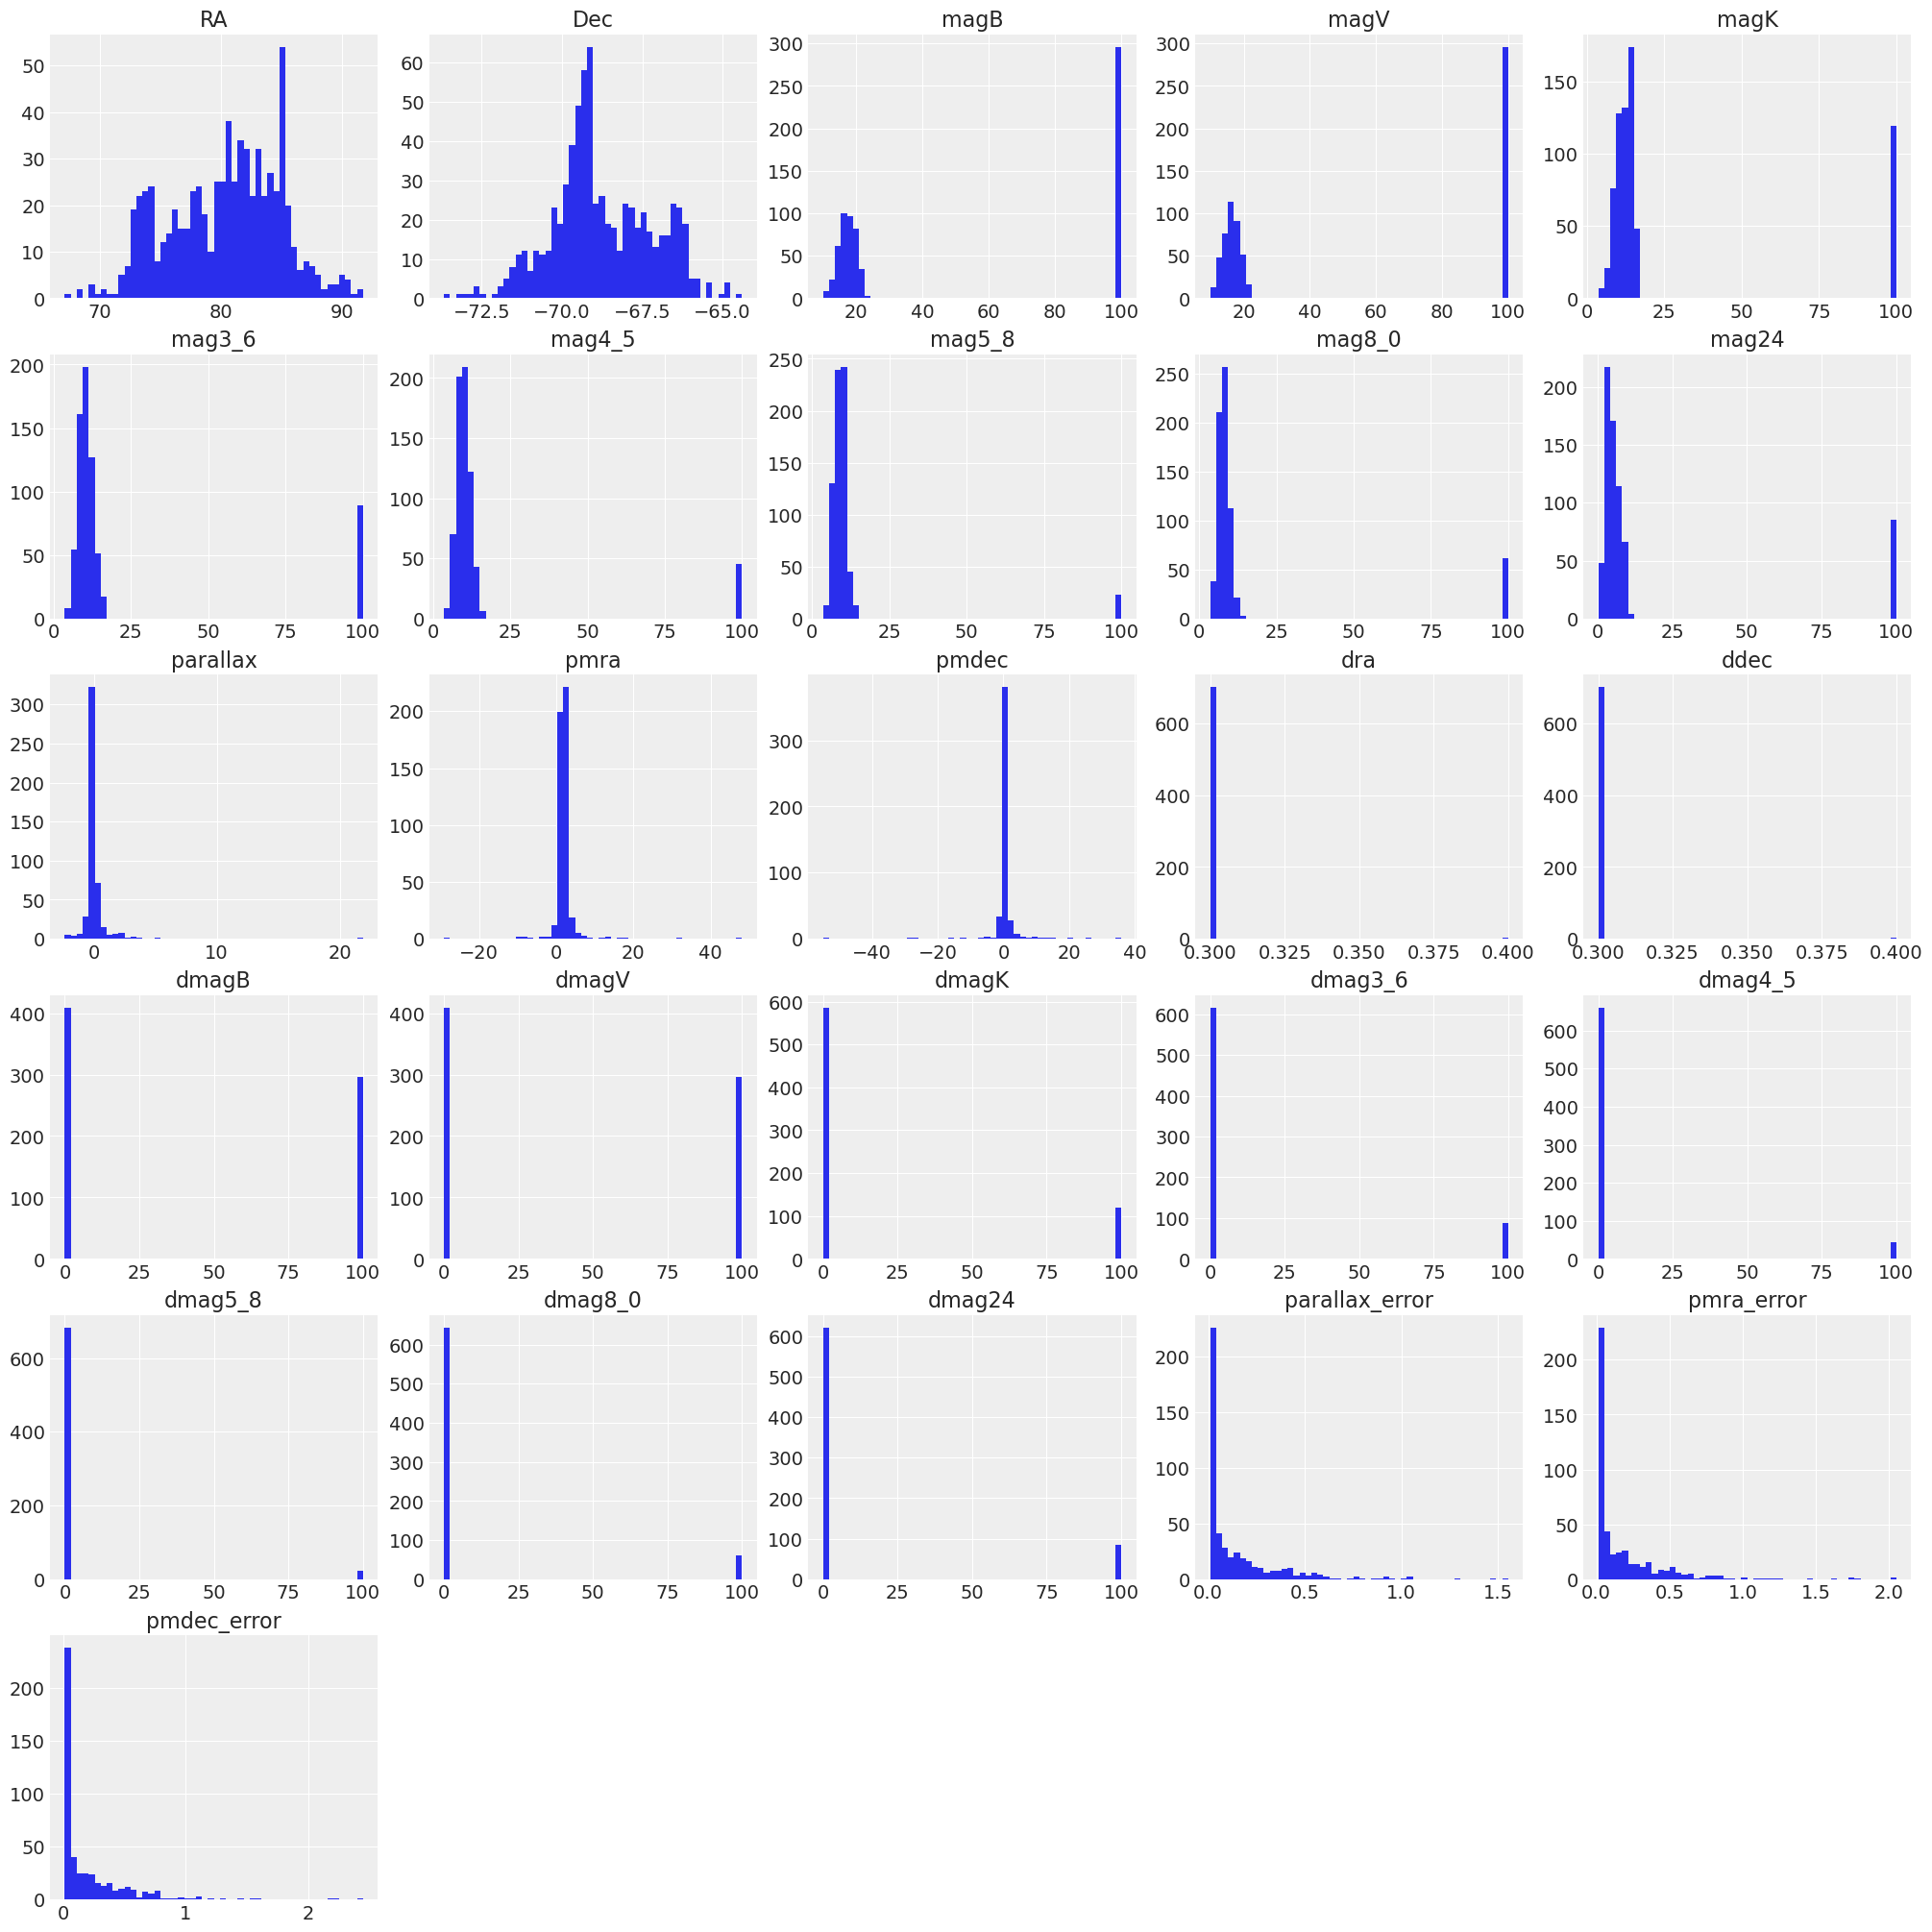

In [9]:
df_dev.hist(figsize=(20, 20), bins=50)

In [36]:
print(np.isnan(df['Jones_Spec_Label']))

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

Define our model

In [ ]:
def construct_nn(ann_input, ann_output):    
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = rng.standard_normal(size=(X_train.shape[1], n_hidden)).astype(floatX)
    init_2 = rng.standard_normal(size=(n_hidden, n_hidden)).astype(floatX)
    init_out = rng.standard_normal(size=n_hidden).astype(floatX)

    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "hidden_layer_2": np.arange(n_hidden),
        "train_cols": np.arange(X_train.shape[1]),
        "obs_id": np.arange(X_train.shape[0]),
    }

    with pm.Model(coords=coords) as neural_network:
        ann_input = pm.Data("ann_input", X_train, dims=("obs_id", "train_cols"))
        ann_output = pm.Data("ann_output", Y_train, dims="obs_id")

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal(
            "w_in_1", 0, sigma=1, initval=init_1, dims=("train_cols", "hidden_layer_1")
        )

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal(
            "w_1_2", 0, sigma=1, initval=init_2, dims=("hidden_layer_1", "hidden_layer_2")
        )

        # Weights from hidden layer to output
        weights_2_out = pm.Normal("w_2_out", 0, sigma=1, initval=init_out, dims="hidden_layer_2")

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Categorical(
            "out",
            act_out,
            observed=ann_output,
            total_size=Y_train.shape[0],  # IMPORTANT for minibatches
            dims="obs_id",
        )
    return neural_network

In [19]:
nn = construct_nn(X_train, Y_train)

NotImplementedError: Masked arrays or arrays with `nan` entries are not supported. Pass them directly to `observed` if you want to trigger auto-imputation

In [37]:
print(Y_train)
print(Y_train.codes)

['     HII', '    CAGB', '    RCrB', '    YSO3', '    YSO3', ..., '     CPN', '    RCrB', '   CPAGB', 'HII/YSO3', '     RSG']
Length: 564
Categories (25, object): ['      WR', '     BSG', '     CPN', '     GAL', ..., '   CPAGB', '   OPAGB', '   RVTau', 'HII/YSO3']
[ 4 12 15 19 19 20 12  7 14 14 18 19 12 12 14 24 19 21  4  6 12  7 19  3
  4 17 22 19 12 19 22 12 19  7 12  7 12 12  2 20 12  4  4 18 12  7  4  4
  4  7  7 17 18 12 19 17 12  5 19 14 14 12 19 12  7 14  7  6  6 18 14 12
  3 17 12 12 11 20 19 12 20 17 12 24 17 12  7  7 17 16 12  6 12  4 12 12
 16  7 19  4 12  4 14  9 16 12  7 17  4  4 14 19  2 17 24  9 16 14 24 14
  7  7 17 19 12 19  7  4 14 18 12 17  4  4 17 17 11 19  4  7 17 14 12  4
  9  6 20 24 21  7  7 14 14 18  4  7 23  4  7 22 16  4  0 21 10  7  1  4
  3 12 14 23 12 14 19 12 17  4 12 12 12  0 12 15  7  7  4 14  7 22  4  4
 15 12 12  7 14 12 21 24  6 20  7 14 14  4 16 19  0  2 12  4 18  7 20  6
 14 19  6  7 24 18 17  4 19 17 12 12 12 19 22 19  6 12 24 12  4 20 14 18
 19 1

In [8]:
import numpy as np
import pandas as pd
import pytensor.tensor as tt

def construct_nn_with_uncertainty(ann_input, ann_output, input_uncertainties, censoring_info=None):
    n_samples, n_features = ann_input.shape
    n_outputs = len(np.unique(ann_output))

    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = rng.standard_normal(size=(n_features, n_hidden)).astype(floatX)
    init_2 = rng.standard_normal(size=(n_hidden, n_hidden)).astype(floatX)
    init_out = rng.standard_normal(size=n_hidden).astype(floatX)

    # Identify missing data mask
    missing_mask = np.isnan(ann_input)

    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "hidden_layer_2": np.arange(n_hidden),
        "train_cols": np.arange(n_features),
        "obs_id": np.arange(n_samples),
    }
    
    with pm.Model(coords=coords) as neural_network:
        # Latent true input variables
        true_inputs = pm.Normal('true_inputs', mu=0, sigma=1, shape=(n_samples, n_features))
        
        # Observed inputs modeled with measurement uncertainties
        pm.Normal(
            'observed_inputs',
            mu=true_inputs,
            sigma=input_uncertainties,
            observed=ann_input
        )
        
        # Impute missing values
        imputed_inputs = tt.switch(missing_mask, true_inputs, ann_input)
        
        # Define priors for weights and biases
        weights_in_1 = pm.Normal('weights_in_1', mu=0, sigma=1, initval=init_1, dims=("train_cols", "hidden_layer_1"))
        # biases_1 = pm.Normal('biases_1', mu=0, sigma=1, shape=(n_hidden,))

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal(
            "w_1_2", 0, sigma=1, initval=init_2, dims=("hidden_layer_1", "hidden_layer_2")
        )
        
        weights_2_out = pm.Normal('weights_1_out', mu=0, sigma=1, initval=init_out, dims="hidden_layer_2")
        # biases_out = pm.Normal('biases_out', mu=0, sigma=1, shape=(n_outputs,))
        
        # # Neural network layers using latent true inputs
        # hidden_layer = tt.nnet.relu(pm.math.dot(imputed_inputs, weights_in_1) + biases_1)
        # output_logits = pm.math.dot(hidden_layer, weights_1_out) + biases_out

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(imputed_inputs, weights_in_1))  #ann_input
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

        print(act_out.shape, act_out.dtype)
        print(ann_output.shape, ann_output.dtype)
        
        # Handle censored data if provided
        if censoring_info is not None:
            is_censored = censoring_info['is_censored']
            censoring_threshold = censoring_info['threshold']
            
            # Observed data (not censored)
            observed_data = ann_output[~is_censored]
            observed_logits = act_out[~is_censored]
            
            # Censored data
            censored_logits = act_out[is_censored]
            
            # Likelihood for observed data
            pm.Categorical('observed_outcomes', observed_logits, observed=observed_data)
            
            # Likelihood for censored data using pm.Potential
            censored_logp = pm.logcdf(pm.Categorical.dist(logits=censored_logits), censoring_threshold)
            pm.Potential('censored_logp', censored_logp.sum())
        else:
            # Standard likelihood for all data
            pm.Categorical('outcomes', act_out, observed=ann_output)
        
    return neural_network

In [9]:
x_train_uncertainties = X_train[dev_col_subset_uncs].values
x_train = X_train[dev_col_subset].values
y_train = Y_train.codes

print(x_train_uncertainties.shape, x_train.shape, y_train.shape)

(564, 13) (564, 13) (564,)


In [10]:
nn = construct_nn_with_uncertainty(x_train, y_train, x_train_uncertainties)

Shape.0 float64
(564,) int8


/home/peter/GitHub/LMC_Machine_Learning/.pixi/envs/default/lib/python3.12/site-packages/pymc/model/core.py:1278: ImputationWarning: Data in observed_inputs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [17]:
with nn:
    advi = pm.ADVI()
    print(advi.approx)
    print(advi.approx.shared_params)
    print(advi.approx.groups)
    print(advi.approx.mean.eval())
    print(advi.approx.std.eval())
    tracker = pm.callbacks.Tracker(
        mean=advi.approx.mean.eval,  # callable that returns mean
        std=advi.approx.std.eval,  # callable that returns std
    )
    approx = advi.fit(10, callbacks=[tracker])

Approximation{MeanFieldGroup[7979]}
{'mu': mu, 'rho': rho}
[ 0.          0.          0.         ... -1.4167195   0.51579539
 -2.32545632]
[0.69314718 0.69314718 0.69314718 ... 0.69314718 0.69314718 0.69314718]


/home/peter/GitHub/LMC_Machine_Learning/.pixi/envs/default/lib/python3.12/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

FloatingPointError: NaN occurred in optimization. 
The current approximation of RV `true_inputs`.ravel()[10] is NaN.
The current approximation of RV `true_inputs`.ravel()[11] is NaN.
The current approximation of RV `true_inputs`.ravel()[12] is NaN.
The current approximation of RV `true_inputs`.ravel()[23] is NaN.
The current approximation of RV `true_inputs`.ravel()[24] is NaN.
The current approximation of RV `true_inputs`.ravel()[25] is NaN.
The current approximation of RV `true_inputs`.ravel()[75] is NaN.
The current approximation of RV `true_inputs`.ravel()[76] is NaN.
The current approximation of RV `true_inputs`.ravel()[77] is NaN.
The current approximation of RV `true_inputs`.ravel()[88] is NaN.
The current approximation of RV `true_inputs`.ravel()[89] is NaN.
The current approximation of RV `true_inputs`.ravel()[90] is NaN.
The current approximation of RV `true_inputs`.ravel()[140] is NaN.
The current approximation of RV `true_inputs`.ravel()[141] is NaN.
The current approximation of RV `true_inputs`.ravel()[142] is NaN.
The current approximation of RV `true_inputs`.ravel()[153] is NaN.
The current approximation of RV `true_inputs`.ravel()[154] is NaN.
The current approximation of RV `true_inputs`.ravel()[155] is NaN.
The current approximation of RV `true_inputs`.ravel()[179] is NaN.
The current approximation of RV `true_inputs`.ravel()[180] is NaN.
The current approximation of RV `true_inputs`.ravel()[181] is NaN.
The current approximation of RV `true_inputs`.ravel()[257] is NaN.
The current approximation of RV `true_inputs`.ravel()[258] is NaN.
The current approximation of RV `true_inputs`.ravel()[259] is NaN.
The current approximation of RV `true_inputs`.ravel()[296] is NaN.
The current approximation of RV `true_inputs`.ravel()[297] is NaN.
The current approximation of RV `true_inputs`.ravel()[298] is NaN.
The current approximation of RV `true_inputs`.ravel()[335] is NaN.
The current approximation of RV `true_inputs`.ravel()[336] is NaN.
The current approximation of RV `true_inputs`.ravel()[337] is NaN.
The current approximation of RV `true_inputs`.ravel()[374] is NaN.
The current approximation of RV `true_inputs`.ravel()[375] is NaN.
The current approximation of RV `true_inputs`.ravel()[376] is NaN.
The current approximation of RV `true_inputs`.ravel()[413] is NaN.
The current approximation of RV `true_inputs`.ravel()[414] is NaN.
The current approximation of RV `true_inputs`.ravel()[415] is NaN.
The current approximation of RV `true_inputs`.ravel()[491] is NaN.
The current approximation of RV `true_inputs`.ravel()[492] is NaN.
The current approximation of RV `true_inputs`.ravel()[493] is NaN.
The current approximation of RV `true_inputs`.ravel()[530] is NaN.
The current approximation of RV `true_inputs`.ravel()[531] is NaN.
The current approximation of RV `true_inputs`.ravel()[532] is NaN.
The current approximation of RV `true_inputs`.ravel()[543] is NaN.
The current approximation of RV `true_inputs`.ravel()[544] is NaN.
The current approximation of RV `true_inputs`.ravel()[545] is NaN.
The current approximation of RV `true_inputs`.ravel()[569] is NaN.
The current approximation of RV `true_inputs`.ravel()[570] is NaN.
The current approximation of RV `true_inputs`.ravel()[571] is NaN.
The current approximation of RV `true_inputs`.ravel()[582] is NaN.
The current approximation of RV `true_inputs`.ravel()[583] is NaN.
The current approximation of RV `true_inputs`.ravel()[584] is NaN.
The current approximation of RV `true_inputs`.ravel()[621] is NaN.
The current approximation of RV `true_inputs`.ravel()[622] is NaN.
The current approximation of RV `true_inputs`.ravel()[623] is NaN.
The current approximation of RV `true_inputs`.ravel()[634] is NaN.
The current approximation of RV `true_inputs`.ravel()[635] is NaN.
The current approximation of RV `true_inputs`.ravel()[636] is NaN.
The current approximation of RV `true_inputs`.ravel()[673] is NaN.
The current approximation of RV `true_inputs`.ravel()[674] is NaN.
The current approximation of RV `true_inputs`.ravel()[675] is NaN.
The current approximation of RV `true_inputs`.ravel()[686] is NaN.
The current approximation of RV `true_inputs`.ravel()[687] is NaN.
The current approximation of RV `true_inputs`.ravel()[688] is NaN.
The current approximation of RV `true_inputs`.ravel()[699] is NaN.
The current approximation of RV `true_inputs`.ravel()[700] is NaN.
The current approximation of RV `true_inputs`.ravel()[701] is NaN.
The current approximation of RV `true_inputs`.ravel()[725] is NaN.
The current approximation of RV `true_inputs`.ravel()[726] is NaN.
The current approximation of RV `true_inputs`.ravel()[727] is NaN.
The current approximation of RV `true_inputs`.ravel()[738] is NaN.
The current approximation of RV `true_inputs`.ravel()[739] is NaN.
The current approximation of RV `true_inputs`.ravel()[740] is NaN.
The current approximation of RV `true_inputs`.ravel()[816] is NaN.
The current approximation of RV `true_inputs`.ravel()[817] is NaN.
The current approximation of RV `true_inputs`.ravel()[818] is NaN.
The current approximation of RV `true_inputs`.ravel()[829] is NaN.
The current approximation of RV `true_inputs`.ravel()[830] is NaN.
The current approximation of RV `true_inputs`.ravel()[831] is NaN.
The current approximation of RV `true_inputs`.ravel()[907] is NaN.
The current approximation of RV `true_inputs`.ravel()[908] is NaN.
The current approximation of RV `true_inputs`.ravel()[909] is NaN.
The current approximation of RV `true_inputs`.ravel()[946] is NaN.
The current approximation of RV `true_inputs`.ravel()[947] is NaN.
The current approximation of RV `true_inputs`.ravel()[948] is NaN.
The current approximation of RV `true_inputs`.ravel()[985] is NaN.
The current approximation of RV `true_inputs`.ravel()[986] is NaN.
The current approximation of RV `true_inputs`.ravel()[987] is NaN.
The current approximation of RV `true_inputs`.ravel()[1011] is NaN.
The current approximation of RV `true_inputs`.ravel()[1012] is NaN.
The current approximation of RV `true_inputs`.ravel()[1013] is NaN.
The current approximation of RV `true_inputs`.ravel()[1024] is NaN.
The current approximation of RV `true_inputs`.ravel()[1025] is NaN.
The current approximation of RV `true_inputs`.ravel()[1026] is NaN.
The current approximation of RV `true_inputs`.ravel()[1063] is NaN.
The current approximation of RV `true_inputs`.ravel()[1064] is NaN.
The current approximation of RV `true_inputs`.ravel()[1065] is NaN.
The current approximation of RV `true_inputs`.ravel()[1076] is NaN.
The current approximation of RV `true_inputs`.ravel()[1077] is NaN.
The current approximation of RV `true_inputs`.ravel()[1078] is NaN.
The current approximation of RV `true_inputs`.ravel()[1089] is NaN.
The current approximation of RV `true_inputs`.ravel()[1090] is NaN.
The current approximation of RV `true_inputs`.ravel()[1091] is NaN.
The current approximation of RV `true_inputs`.ravel()[1102] is NaN.
The current approximation of RV `true_inputs`.ravel()[1103] is NaN.
The current approximation of RV `true_inputs`.ravel()[1104] is NaN.
The current approximation of RV `true_inputs`.ravel()[1115] is NaN.
The current approximation of RV `true_inputs`.ravel()[1116] is NaN.
The current approximation of RV `true_inputs`.ravel()[1117] is NaN.
The current approximation of RV `true_inputs`.ravel()[1154] is NaN.
The current approximation of RV `true_inputs`.ravel()[1155] is NaN.
The current approximation of RV `true_inputs`.ravel()[1156] is NaN.
The current approximation of RV `true_inputs`.ravel()[1180] is NaN.
The current approximation of RV `true_inputs`.ravel()[1181] is NaN.
The current approximation of RV `true_inputs`.ravel()[1182] is NaN.
The current approximation of RV `true_inputs`.ravel()[1206] is NaN.
The current approximation of RV `true_inputs`.ravel()[1207] is NaN.
The current approximation of RV `true_inputs`.ravel()[1208] is NaN.
The current approximation of RV `true_inputs`.ravel()[1245] is NaN.
The current approximation of RV `true_inputs`.ravel()[1246] is NaN.
The current approximation of RV `true_inputs`.ravel()[1247] is NaN.
The current approximation of RV `true_inputs`.ravel()[1310] is NaN.
The current approximation of RV `true_inputs`.ravel()[1311] is NaN.
The current approximation of RV `true_inputs`.ravel()[1312] is NaN.
The current approximation of RV `true_inputs`.ravel()[1401] is NaN.
The current approximation of RV `true_inputs`.ravel()[1402] is NaN.
The current approximation of RV `true_inputs`.ravel()[1403] is NaN.
The current approximation of RV `true_inputs`.ravel()[1414] is NaN.
The current approximation of RV `true_inputs`.ravel()[1415] is NaN.
The current approximation of RV `true_inputs`.ravel()[1416] is NaN.
The current approximation of RV `true_inputs`.ravel()[1427] is NaN.
The current approximation of RV `true_inputs`.ravel()[1428] is NaN.
The current approximation of RV `true_inputs`.ravel()[1429] is NaN.
The current approximation of RV `true_inputs`.ravel()[1453] is NaN.
The current approximation of RV `true_inputs`.ravel()[1454] is NaN.
The current approximation of RV `true_inputs`.ravel()[1455] is NaN.
The current approximation of RV `true_inputs`.ravel()[1466] is NaN.
The current approximation of RV `true_inputs`.ravel()[1467] is NaN.
The current approximation of RV `true_inputs`.ravel()[1468] is NaN.
The current approximation of RV `true_inputs`.ravel()[1479] is NaN.
The current approximation of RV `true_inputs`.ravel()[1480] is NaN.
The current approximation of RV `true_inputs`.ravel()[1481] is NaN.
The current approximation of RV `true_inputs`.ravel()[1544] is NaN.
The current approximation of RV `true_inputs`.ravel()[1545] is NaN.
The current approximation of RV `true_inputs`.ravel()[1546] is NaN.
The current approximation of RV `true_inputs`.ravel()[1557] is NaN.
The current approximation of RV `true_inputs`.ravel()[1558] is NaN.
The current approximation of RV `true_inputs`.ravel()[1559] is NaN.
The current approximation of RV `true_inputs`.ravel()[1596] is NaN.
The current approximation of RV `true_inputs`.ravel()[1597] is NaN.
The current approximation of RV `true_inputs`.ravel()[1598] is NaN.
The current approximation of RV `true_inputs`.ravel()[1661] is NaN.
The current approximation of RV `true_inputs`.ravel()[1662] is NaN.
The current approximation of RV `true_inputs`.ravel()[1663] is NaN.
The current approximation of RV `true_inputs`.ravel()[1674] is NaN.
The current approximation of RV `true_inputs`.ravel()[1675] is NaN.
The current approximation of RV `true_inputs`.ravel()[1676] is NaN.
The current approximation of RV `true_inputs`.ravel()[1687] is NaN.
The current approximation of RV `true_inputs`.ravel()[1688] is NaN.
The current approximation of RV `true_inputs`.ravel()[1689] is NaN.
The current approximation of RV `true_inputs`.ravel()[1700] is NaN.
The current approximation of RV `true_inputs`.ravel()[1701] is NaN.
The current approximation of RV `true_inputs`.ravel()[1702] is NaN.
The current approximation of RV `true_inputs`.ravel()[1713] is NaN.
The current approximation of RV `true_inputs`.ravel()[1714] is NaN.
The current approximation of RV `true_inputs`.ravel()[1715] is NaN.
The current approximation of RV `true_inputs`.ravel()[1739] is NaN.
The current approximation of RV `true_inputs`.ravel()[1740] is NaN.
The current approximation of RV `true_inputs`.ravel()[1741] is NaN.
The current approximation of RV `true_inputs`.ravel()[1765] is NaN.
The current approximation of RV `true_inputs`.ravel()[1766] is NaN.
The current approximation of RV `true_inputs`.ravel()[1767] is NaN.
The current approximation of RV `true_inputs`.ravel()[1804] is NaN.
The current approximation of RV `true_inputs`.ravel()[1805] is NaN.
The current approximation of RV `true_inputs`.ravel()[1806] is NaN.
The current approximation of RV `true_inputs`.ravel()[1830] is NaN.
The current approximation of RV `true_inputs`.ravel()[1831] is NaN.
The current approximation of RV `true_inputs`.ravel()[1832] is NaN.
The current approximation of RV `true_inputs`.ravel()[1856] is NaN.
The current approximation of RV `true_inputs`.ravel()[1857] is NaN.
The current approximation of RV `true_inputs`.ravel()[1858] is NaN.
The current approximation of RV `true_inputs`.ravel()[1895] is NaN.
The current approximation of RV `true_inputs`.ravel()[1896] is NaN.
The current approximation of RV `true_inputs`.ravel()[1897] is NaN.
The current approximation of RV `true_inputs`.ravel()[1921] is NaN.
The current approximation of RV `true_inputs`.ravel()[1922] is NaN.
The current approximation of RV `true_inputs`.ravel()[1923] is NaN.
The current approximation of RV `true_inputs`.ravel()[1999] is NaN.
The current approximation of RV `true_inputs`.ravel()[2000] is NaN.
The current approximation of RV `true_inputs`.ravel()[2001] is NaN.
The current approximation of RV `true_inputs`.ravel()[2051] is NaN.
The current approximation of RV `true_inputs`.ravel()[2052] is NaN.
The current approximation of RV `true_inputs`.ravel()[2053] is NaN.
The current approximation of RV `true_inputs`.ravel()[2103] is NaN.
The current approximation of RV `true_inputs`.ravel()[2104] is NaN.
The current approximation of RV `true_inputs`.ravel()[2105] is NaN.
The current approximation of RV `true_inputs`.ravel()[2148] is NaN.
The current approximation of RV `true_inputs`.ravel()[2194] is NaN.
The current approximation of RV `true_inputs`.ravel()[2195] is NaN.
The current approximation of RV `true_inputs`.ravel()[2196] is NaN.
The current approximation of RV `true_inputs`.ravel()[2272] is NaN.
The current approximation of RV `true_inputs`.ravel()[2273] is NaN.
The current approximation of RV `true_inputs`.ravel()[2274] is NaN.
The current approximation of RV `true_inputs`.ravel()[2311] is NaN.
The current approximation of RV `true_inputs`.ravel()[2312] is NaN.
The current approximation of RV `true_inputs`.ravel()[2313] is NaN.
The current approximation of RV `true_inputs`.ravel()[2350] is NaN.
The current approximation of RV `true_inputs`.ravel()[2351] is NaN.
The current approximation of RV `true_inputs`.ravel()[2352] is NaN.
The current approximation of RV `true_inputs`.ravel()[2376] is NaN.
The current approximation of RV `true_inputs`.ravel()[2377] is NaN.
The current approximation of RV `true_inputs`.ravel()[2378] is NaN.
The current approximation of RV `true_inputs`.ravel()[2428] is NaN.
The current approximation of RV `true_inputs`.ravel()[2429] is NaN.
The current approximation of RV `true_inputs`.ravel()[2430] is NaN.
The current approximation of RV `true_inputs`.ravel()[2493] is NaN.
The current approximation of RV `true_inputs`.ravel()[2494] is NaN.
The current approximation of RV `true_inputs`.ravel()[2495] is NaN.
The current approximation of RV `true_inputs`.ravel()[2519] is NaN.
The current approximation of RV `true_inputs`.ravel()[2520] is NaN.
The current approximation of RV `true_inputs`.ravel()[2521] is NaN.
The current approximation of RV `true_inputs`.ravel()[2597] is NaN.
The current approximation of RV `true_inputs`.ravel()[2598] is NaN.
The current approximation of RV `true_inputs`.ravel()[2599] is NaN.
The current approximation of RV `true_inputs`.ravel()[2701] is NaN.
The current approximation of RV `true_inputs`.ravel()[2702] is NaN.
The current approximation of RV `true_inputs`.ravel()[2703] is NaN.
The current approximation of RV `true_inputs`.ravel()[2753] is NaN.
The current approximation of RV `true_inputs`.ravel()[2754] is NaN.
The current approximation of RV `true_inputs`.ravel()[2755] is NaN.
The current approximation of RV `true_inputs`.ravel()[2844] is NaN.
The current approximation of RV `true_inputs`.ravel()[2845] is NaN.
The current approximation of RV `true_inputs`.ravel()[2846] is NaN.
The current approximation of RV `true_inputs`.ravel()[2870] is NaN.
The current approximation of RV `true_inputs`.ravel()[2871] is NaN.
The current approximation of RV `true_inputs`.ravel()[2872] is NaN.
The current approximation of RV `true_inputs`.ravel()[2883] is NaN.
The current approximation of RV `true_inputs`.ravel()[2884] is NaN.
The current approximation of RV `true_inputs`.ravel()[2885] is NaN.
The current approximation of RV `true_inputs`.ravel()[2896] is NaN.
The current approximation of RV `true_inputs`.ravel()[2897] is NaN.
The current approximation of RV `true_inputs`.ravel()[2898] is NaN.
The current approximation of RV `true_inputs`.ravel()[2909] is NaN.
The current approximation of RV `true_inputs`.ravel()[2910] is NaN.
The current approximation of RV `true_inputs`.ravel()[2911] is NaN.
The current approximation of RV `true_inputs`.ravel()[2935] is NaN.
The current approximation of RV `true_inputs`.ravel()[2936] is NaN.
The current approximation of RV `true_inputs`.ravel()[2937] is NaN.
The current approximation of RV `true_inputs`.ravel()[3013] is NaN.
The current approximation of RV `true_inputs`.ravel()[3014] is NaN.
The current approximation of RV `true_inputs`.ravel()[3015] is NaN.
The current approximation of RV `true_inputs`.ravel()[3026] is NaN.
The current approximation of RV `true_inputs`.ravel()[3027] is NaN.
The current approximation of RV `true_inputs`.ravel()[3028] is NaN.
The current approximation of RV `true_inputs`.ravel()[3039] is NaN.
The current approximation of RV `true_inputs`.ravel()[3040] is NaN.
The current approximation of RV `true_inputs`.ravel()[3041] is NaN.
The current approximation of RV `true_inputs`.ravel()[3052] is NaN.
The current approximation of RV `true_inputs`.ravel()[3053] is NaN.
The current approximation of RV `true_inputs`.ravel()[3054] is NaN.
The current approximation of RV `true_inputs`.ravel()[3130] is NaN.
The current approximation of RV `true_inputs`.ravel()[3131] is NaN.
The current approximation of RV `true_inputs`.ravel()[3132] is NaN.
The current approximation of RV `true_inputs`.ravel()[3143] is NaN.
The current approximation of RV `true_inputs`.ravel()[3144] is NaN.
The current approximation of RV `true_inputs`.ravel()[3145] is NaN.
The current approximation of RV `true_inputs`.ravel()[3195] is NaN.
The current approximation of RV `true_inputs`.ravel()[3196] is NaN.
The current approximation of RV `true_inputs`.ravel()[3197] is NaN.
The current approximation of RV `true_inputs`.ravel()[3221] is NaN.
The current approximation of RV `true_inputs`.ravel()[3222] is NaN.
The current approximation of RV `true_inputs`.ravel()[3223] is NaN.
The current approximation of RV `true_inputs`.ravel()[3299] is NaN.
The current approximation of RV `true_inputs`.ravel()[3300] is NaN.
The current approximation of RV `true_inputs`.ravel()[3301] is NaN.
The current approximation of RV `true_inputs`.ravel()[3312] is NaN.
The current approximation of RV `true_inputs`.ravel()[3313] is NaN.
The current approximation of RV `true_inputs`.ravel()[3314] is NaN.
The current approximation of RV `true_inputs`.ravel()[3377] is NaN.
The current approximation of RV `true_inputs`.ravel()[3378] is NaN.
The current approximation of RV `true_inputs`.ravel()[3379] is NaN.
The current approximation of RV `true_inputs`.ravel()[3468] is NaN.
The current approximation of RV `true_inputs`.ravel()[3469] is NaN.
The current approximation of RV `true_inputs`.ravel()[3470] is NaN.
The current approximation of RV `true_inputs`.ravel()[3481] is NaN.
The current approximation of RV `true_inputs`.ravel()[3482] is NaN.
The current approximation of RV `true_inputs`.ravel()[3483] is NaN.
The current approximation of RV `true_inputs`.ravel()[3494] is NaN.
The current approximation of RV `true_inputs`.ravel()[3495] is NaN.
The current approximation of RV `true_inputs`.ravel()[3496] is NaN.
The current approximation of RV `true_inputs`.ravel()[3577] is NaN.
The current approximation of RV `true_inputs`.ravel()[3650] is NaN.
The current approximation of RV `true_inputs`.ravel()[3651] is NaN.
The current approximation of RV `true_inputs`.ravel()[3652] is NaN.
The current approximation of RV `true_inputs`.ravel()[3767] is NaN.
The current approximation of RV `true_inputs`.ravel()[3768] is NaN.
The current approximation of RV `true_inputs`.ravel()[3769] is NaN.
The current approximation of RV `true_inputs`.ravel()[3780] is NaN.
The current approximation of RV `true_inputs`.ravel()[3781] is NaN.
The current approximation of RV `true_inputs`.ravel()[3782] is NaN.
The current approximation of RV `true_inputs`.ravel()[3806] is NaN.
The current approximation of RV `true_inputs`.ravel()[3807] is NaN.
The current approximation of RV `true_inputs`.ravel()[3808] is NaN.
The current approximation of RV `true_inputs`.ravel()[3832] is NaN.
The current approximation of RV `true_inputs`.ravel()[3833] is NaN.
The current approximation of RV `true_inputs`.ravel()[3834] is NaN.
The current approximation of RV `true_inputs`.ravel()[3858] is NaN.
The current approximation of RV `true_inputs`.ravel()[3859] is NaN.
The current approximation of RV `true_inputs`.ravel()[3860] is NaN.
The current approximation of RV `true_inputs`.ravel()[3884] is NaN.
The current approximation of RV `true_inputs`.ravel()[3885] is NaN.
The current approximation of RV `true_inputs`.ravel()[3886] is NaN.
The current approximation of RV `true_inputs`.ravel()[3910] is NaN.
The current approximation of RV `true_inputs`.ravel()[3911] is NaN.
The current approximation of RV `true_inputs`.ravel()[3912] is NaN.
The current approximation of RV `true_inputs`.ravel()[3962] is NaN.
The current approximation of RV `true_inputs`.ravel()[3963] is NaN.
The current approximation of RV `true_inputs`.ravel()[3964] is NaN.
The current approximation of RV `true_inputs`.ravel()[4040] is NaN.
The current approximation of RV `true_inputs`.ravel()[4041] is NaN.
The current approximation of RV `true_inputs`.ravel()[4042] is NaN.
The current approximation of RV `true_inputs`.ravel()[4053] is NaN.
The current approximation of RV `true_inputs`.ravel()[4054] is NaN.
The current approximation of RV `true_inputs`.ravel()[4055] is NaN.
The current approximation of RV `true_inputs`.ravel()[4066] is NaN.
The current approximation of RV `true_inputs`.ravel()[4067] is NaN.
The current approximation of RV `true_inputs`.ravel()[4068] is NaN.
The current approximation of RV `true_inputs`.ravel()[4131] is NaN.
The current approximation of RV `true_inputs`.ravel()[4132] is NaN.
The current approximation of RV `true_inputs`.ravel()[4133] is NaN.
The current approximation of RV `true_inputs`.ravel()[4157] is NaN.
The current approximation of RV `true_inputs`.ravel()[4158] is NaN.
The current approximation of RV `true_inputs`.ravel()[4159] is NaN.
The current approximation of RV `true_inputs`.ravel()[4222] is NaN.
The current approximation of RV `true_inputs`.ravel()[4223] is NaN.
The current approximation of RV `true_inputs`.ravel()[4224] is NaN.
The current approximation of RV `true_inputs`.ravel()[4300] is NaN.
The current approximation of RV `true_inputs`.ravel()[4301] is NaN.
The current approximation of RV `true_inputs`.ravel()[4302] is NaN.
The current approximation of RV `true_inputs`.ravel()[4313] is NaN.
The current approximation of RV `true_inputs`.ravel()[4314] is NaN.
The current approximation of RV `true_inputs`.ravel()[4315] is NaN.
The current approximation of RV `true_inputs`.ravel()[4326] is NaN.
The current approximation of RV `true_inputs`.ravel()[4327] is NaN.
The current approximation of RV `true_inputs`.ravel()[4328] is NaN.
The current approximation of RV `true_inputs`.ravel()[4339] is NaN.
The current approximation of RV `true_inputs`.ravel()[4340] is NaN.
The current approximation of RV `true_inputs`.ravel()[4341] is NaN.
The current approximation of RV `true_inputs`.ravel()[4417] is NaN.
The current approximation of RV `true_inputs`.ravel()[4418] is NaN.
The current approximation of RV `true_inputs`.ravel()[4419] is NaN.
The current approximation of RV `true_inputs`.ravel()[4495] is NaN.
The current approximation of RV `true_inputs`.ravel()[4496] is NaN.
The current approximation of RV `true_inputs`.ravel()[4497] is NaN.
The current approximation of RV `true_inputs`.ravel()[4508] is NaN.
The current approximation of RV `true_inputs`.ravel()[4509] is NaN.
The current approximation of RV `true_inputs`.ravel()[4510] is NaN.
The current approximation of RV `true_inputs`.ravel()[4534] is NaN.
The current approximation of RV `true_inputs`.ravel()[4535] is NaN.
The current approximation of RV `true_inputs`.ravel()[4536] is NaN.
The current approximation of RV `true_inputs`.ravel()[4560] is NaN.
The current approximation of RV `true_inputs`.ravel()[4561] is NaN.
The current approximation of RV `true_inputs`.ravel()[4562] is NaN.
The current approximation of RV `true_inputs`.ravel()[4586] is NaN.
The current approximation of RV `true_inputs`.ravel()[4587] is NaN.
The current approximation of RV `true_inputs`.ravel()[4588] is NaN.
The current approximation of RV `true_inputs`.ravel()[4651] is NaN.
The current approximation of RV `true_inputs`.ravel()[4652] is NaN.
The current approximation of RV `true_inputs`.ravel()[4653] is NaN.
The current approximation of RV `true_inputs`.ravel()[4677] is NaN.
The current approximation of RV `true_inputs`.ravel()[4678] is NaN.
The current approximation of RV `true_inputs`.ravel()[4679] is NaN.
The current approximation of RV `true_inputs`.ravel()[4703] is NaN.
The current approximation of RV `true_inputs`.ravel()[4704] is NaN.
The current approximation of RV `true_inputs`.ravel()[4705] is NaN.
The current approximation of RV `true_inputs`.ravel()[4716] is NaN.
The current approximation of RV `true_inputs`.ravel()[4717] is NaN.
The current approximation of RV `true_inputs`.ravel()[4718] is NaN.
The current approximation of RV `true_inputs`.ravel()[4859] is NaN.
The current approximation of RV `true_inputs`.ravel()[4860] is NaN.
The current approximation of RV `true_inputs`.ravel()[4861] is NaN.
The current approximation of RV `true_inputs`.ravel()[4885] is NaN.
The current approximation of RV `true_inputs`.ravel()[4886] is NaN.
The current approximation of RV `true_inputs`.ravel()[4887] is NaN.
The current approximation of RV `true_inputs`.ravel()[4898] is NaN.
The current approximation of RV `true_inputs`.ravel()[4899] is NaN.
The current approximation of RV `true_inputs`.ravel()[4900] is NaN.
The current approximation of RV `true_inputs`.ravel()[4924] is NaN.
The current approximation of RV `true_inputs`.ravel()[4925] is NaN.
The current approximation of RV `true_inputs`.ravel()[4926] is NaN.
The current approximation of RV `true_inputs`.ravel()[4950] is NaN.
The current approximation of RV `true_inputs`.ravel()[4951] is NaN.
The current approximation of RV `true_inputs`.ravel()[4952] is NaN.
The current approximation of RV `true_inputs`.ravel()[4963] is NaN.
The current approximation of RV `true_inputs`.ravel()[4964] is NaN.
The current approximation of RV `true_inputs`.ravel()[4965] is NaN.
The current approximation of RV `true_inputs`.ravel()[4976] is NaN.
The current approximation of RV `true_inputs`.ravel()[4977] is NaN.
The current approximation of RV `true_inputs`.ravel()[4978] is NaN.
The current approximation of RV `true_inputs`.ravel()[4994] is NaN.
The current approximation of RV `true_inputs`.ravel()[4995] is NaN.
The current approximation of RV `true_inputs`.ravel()[5015] is NaN.
The current approximation of RV `true_inputs`.ravel()[5016] is NaN.
The current approximation of RV `true_inputs`.ravel()[5017] is NaN.
The current approximation of RV `true_inputs`.ravel()[5132] is NaN.
The current approximation of RV `true_inputs`.ravel()[5133] is NaN.
The current approximation of RV `true_inputs`.ravel()[5134] is NaN.
The current approximation of RV `true_inputs`.ravel()[5158] is NaN.
The current approximation of RV `true_inputs`.ravel()[5159] is NaN.
The current approximation of RV `true_inputs`.ravel()[5160] is NaN.
The current approximation of RV `true_inputs`.ravel()[5171] is NaN.
The current approximation of RV `true_inputs`.ravel()[5172] is NaN.
The current approximation of RV `true_inputs`.ravel()[5173] is NaN.
The current approximation of RV `true_inputs`.ravel()[5210] is NaN.
The current approximation of RV `true_inputs`.ravel()[5211] is NaN.
The current approximation of RV `true_inputs`.ravel()[5212] is NaN.
The current approximation of RV `true_inputs`.ravel()[5249] is NaN.
The current approximation of RV `true_inputs`.ravel()[5250] is NaN.
The current approximation of RV `true_inputs`.ravel()[5251] is NaN.
The current approximation of RV `true_inputs`.ravel()[5262] is NaN.
The current approximation of RV `true_inputs`.ravel()[5263] is NaN.
The current approximation of RV `true_inputs`.ravel()[5264] is NaN.
The current approximation of RV `true_inputs`.ravel()[5327] is NaN.
The current approximation of RV `true_inputs`.ravel()[5328] is NaN.
The current approximation of RV `true_inputs`.ravel()[5329] is NaN.
The current approximation of RV `true_inputs`.ravel()[5496] is NaN.
The current approximation of RV `true_inputs`.ravel()[5497] is NaN.
The current approximation of RV `true_inputs`.ravel()[5498] is NaN.
The current approximation of RV `true_inputs`.ravel()[5522] is NaN.
The current approximation of RV `true_inputs`.ravel()[5523] is NaN.
The current approximation of RV `true_inputs`.ravel()[5524] is NaN.
The current approximation of RV `true_inputs`.ravel()[5548] is NaN.
The current approximation of RV `true_inputs`.ravel()[5549] is NaN.
The current approximation of RV `true_inputs`.ravel()[5550] is NaN.
The current approximation of RV `true_inputs`.ravel()[5561] is NaN.
The current approximation of RV `true_inputs`.ravel()[5562] is NaN.
The current approximation of RV `true_inputs`.ravel()[5563] is NaN.
The current approximation of RV `true_inputs`.ravel()[5574] is NaN.
The current approximation of RV `true_inputs`.ravel()[5575] is NaN.
The current approximation of RV `true_inputs`.ravel()[5576] is NaN.
The current approximation of RV `true_inputs`.ravel()[5613] is NaN.
The current approximation of RV `true_inputs`.ravel()[5614] is NaN.
The current approximation of RV `true_inputs`.ravel()[5615] is NaN.
The current approximation of RV `true_inputs`.ravel()[5652] is NaN.
The current approximation of RV `true_inputs`.ravel()[5653] is NaN.
The current approximation of RV `true_inputs`.ravel()[5654] is NaN.
The current approximation of RV `true_inputs`.ravel()[5665] is NaN.
The current approximation of RV `true_inputs`.ravel()[5666] is NaN.
The current approximation of RV `true_inputs`.ravel()[5667] is NaN.
The current approximation of RV `true_inputs`.ravel()[5743] is NaN.
The current approximation of RV `true_inputs`.ravel()[5744] is NaN.
The current approximation of RV `true_inputs`.ravel()[5745] is NaN.
The current approximation of RV `true_inputs`.ravel()[5756] is NaN.
The current approximation of RV `true_inputs`.ravel()[5757] is NaN.
The current approximation of RV `true_inputs`.ravel()[5758] is NaN.
The current approximation of RV `true_inputs`.ravel()[5795] is NaN.
The current approximation of RV `true_inputs`.ravel()[5796] is NaN.
The current approximation of RV `true_inputs`.ravel()[5797] is NaN.
The current approximation of RV `true_inputs`.ravel()[5808] is NaN.
The current approximation of RV `true_inputs`.ravel()[5809] is NaN.
The current approximation of RV `true_inputs`.ravel()[5810] is NaN.
The current approximation of RV `true_inputs`.ravel()[5912] is NaN.
The current approximation of RV `true_inputs`.ravel()[5913] is NaN.
The current approximation of RV `true_inputs`.ravel()[5914] is NaN.
The current approximation of RV `true_inputs`.ravel()[5938] is NaN.
The current approximation of RV `true_inputs`.ravel()[5939] is NaN.
The current approximation of RV `true_inputs`.ravel()[5940] is NaN.
The current approximation of RV `true_inputs`.ravel()[5964] is NaN.
The current approximation of RV `true_inputs`.ravel()[5965] is NaN.
The current approximation of RV `true_inputs`.ravel()[5966] is NaN.
The current approximation of RV `true_inputs`.ravel()[5977] is NaN.
The current approximation of RV `true_inputs`.ravel()[5978] is NaN.
The current approximation of RV `true_inputs`.ravel()[5979] is NaN.
The current approximation of RV `true_inputs`.ravel()[5983] is NaN.
The current approximation of RV `true_inputs`.ravel()[6003] is NaN.
The current approximation of RV `true_inputs`.ravel()[6004] is NaN.
The current approximation of RV `true_inputs`.ravel()[6005] is NaN.
The current approximation of RV `true_inputs`.ravel()[6042] is NaN.
The current approximation of RV `true_inputs`.ravel()[6043] is NaN.
The current approximation of RV `true_inputs`.ravel()[6044] is NaN.
The current approximation of RV `true_inputs`.ravel()[6055] is NaN.
The current approximation of RV `true_inputs`.ravel()[6056] is NaN.
The current approximation of RV `true_inputs`.ravel()[6057] is NaN.
The current approximation of RV `true_inputs`.ravel()[6107] is NaN.
The current approximation of RV `true_inputs`.ravel()[6108] is NaN.
The current approximation of RV `true_inputs`.ravel()[6109] is NaN.
The current approximation of RV `true_inputs`.ravel()[6120] is NaN.
The current approximation of RV `true_inputs`.ravel()[6121] is NaN.
The current approximation of RV `true_inputs`.ravel()[6122] is NaN.
The current approximation of RV `true_inputs`.ravel()[6133] is NaN.
The current approximation of RV `true_inputs`.ravel()[6134] is NaN.
The current approximation of RV `true_inputs`.ravel()[6135] is NaN.
The current approximation of RV `true_inputs`.ravel()[6237] is NaN.
The current approximation of RV `true_inputs`.ravel()[6238] is NaN.
The current approximation of RV `true_inputs`.ravel()[6239] is NaN.
The current approximation of RV `true_inputs`.ravel()[6250] is NaN.
The current approximation of RV `true_inputs`.ravel()[6251] is NaN.
The current approximation of RV `true_inputs`.ravel()[6252] is NaN.
The current approximation of RV `true_inputs`.ravel()[6328] is NaN.
The current approximation of RV `true_inputs`.ravel()[6329] is NaN.
The current approximation of RV `true_inputs`.ravel()[6330] is NaN.
The current approximation of RV `true_inputs`.ravel()[6341] is NaN.
The current approximation of RV `true_inputs`.ravel()[6342] is NaN.
The current approximation of RV `true_inputs`.ravel()[6343] is NaN.
The current approximation of RV `true_inputs`.ravel()[6393] is NaN.
The current approximation of RV `true_inputs`.ravel()[6394] is NaN.
The current approximation of RV `true_inputs`.ravel()[6395] is NaN.
The current approximation of RV `true_inputs`.ravel()[6419] is NaN.
The current approximation of RV `true_inputs`.ravel()[6420] is NaN.
The current approximation of RV `true_inputs`.ravel()[6421] is NaN.
The current approximation of RV `true_inputs`.ravel()[6497] is NaN.
The current approximation of RV `true_inputs`.ravel()[6498] is NaN.
The current approximation of RV `true_inputs`.ravel()[6499] is NaN.
The current approximation of RV `true_inputs`.ravel()[6523] is NaN.
The current approximation of RV `true_inputs`.ravel()[6524] is NaN.
The current approximation of RV `true_inputs`.ravel()[6525] is NaN.
The current approximation of RV `true_inputs`.ravel()[6536] is NaN.
The current approximation of RV `true_inputs`.ravel()[6537] is NaN.
The current approximation of RV `true_inputs`.ravel()[6538] is NaN.
The current approximation of RV `true_inputs`.ravel()[6614] is NaN.
The current approximation of RV `true_inputs`.ravel()[6615] is NaN.
The current approximation of RV `true_inputs`.ravel()[6616] is NaN.
The current approximation of RV `true_inputs`.ravel()[6627] is NaN.
The current approximation of RV `true_inputs`.ravel()[6628] is NaN.
The current approximation of RV `true_inputs`.ravel()[6629] is NaN.
The current approximation of RV `true_inputs`.ravel()[6770] is NaN.
The current approximation of RV `true_inputs`.ravel()[6771] is NaN.
The current approximation of RV `true_inputs`.ravel()[6772] is NaN.
The current approximation of RV `true_inputs`.ravel()[6835] is NaN.
The current approximation of RV `true_inputs`.ravel()[6836] is NaN.
The current approximation of RV `true_inputs`.ravel()[6837] is NaN.
The current approximation of RV `true_inputs`.ravel()[6861] is NaN.
The current approximation of RV `true_inputs`.ravel()[6862] is NaN.
The current approximation of RV `true_inputs`.ravel()[6863] is NaN.
The current approximation of RV `true_inputs`.ravel()[6926] is NaN.
The current approximation of RV `true_inputs`.ravel()[6927] is NaN.
The current approximation of RV `true_inputs`.ravel()[6928] is NaN.
The current approximation of RV `true_inputs`.ravel()[6978] is NaN.
The current approximation of RV `true_inputs`.ravel()[6979] is NaN.
The current approximation of RV `true_inputs`.ravel()[6980] is NaN.
The current approximation of RV `true_inputs`.ravel()[7004] is NaN.
The current approximation of RV `true_inputs`.ravel()[7005] is NaN.
The current approximation of RV `true_inputs`.ravel()[7006] is NaN.
The current approximation of RV `true_inputs`.ravel()[7056] is NaN.
The current approximation of RV `true_inputs`.ravel()[7057] is NaN.
The current approximation of RV `true_inputs`.ravel()[7058] is NaN.
The current approximation of RV `true_inputs`.ravel()[7082] is NaN.
The current approximation of RV `true_inputs`.ravel()[7083] is NaN.
The current approximation of RV `true_inputs`.ravel()[7084] is NaN.
The current approximation of RV `true_inputs`.ravel()[7108] is NaN.
The current approximation of RV `true_inputs`.ravel()[7109] is NaN.
The current approximation of RV `true_inputs`.ravel()[7110] is NaN.
The current approximation of RV `true_inputs`.ravel()[7134] is NaN.
The current approximation of RV `true_inputs`.ravel()[7135] is NaN.
The current approximation of RV `true_inputs`.ravel()[7136] is NaN.
The current approximation of RV `true_inputs`.ravel()[7173] is NaN.
The current approximation of RV `true_inputs`.ravel()[7174] is NaN.
The current approximation of RV `true_inputs`.ravel()[7175] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[0] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[1] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[2] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[3] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[4] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[5] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[6] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[7] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[8] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[9] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[10] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[11] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[12] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[13] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[14] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[15] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[16] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[17] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[18] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[19] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[20] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[21] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[22] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[23] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[24] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[25] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[26] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[27] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[28] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[29] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[30] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[31] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[32] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[33] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[34] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[35] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[36] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[37] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[38] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[39] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[40] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[41] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[42] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[43] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[44] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[45] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[46] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[47] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[48] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[49] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[50] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[51] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[52] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[53] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[54] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[55] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[56] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[57] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[58] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[59] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[60] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[61] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[62] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[63] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[64] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[65] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[66] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[67] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[68] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[69] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[70] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[71] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[72] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[73] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[74] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[75] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[76] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[77] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[78] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[79] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[80] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[81] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[82] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[83] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[84] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[85] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[86] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[87] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[88] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[89] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[90] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[91] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[92] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[93] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[94] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[95] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[96] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[97] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[98] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[99] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[100] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[101] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[102] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[103] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[104] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[105] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[106] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[107] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[108] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[109] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[110] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[111] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[112] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[113] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[114] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[115] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[116] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[117] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[118] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[119] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[120] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[121] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[122] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[123] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[124] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[125] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[126] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[127] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[128] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[129] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[130] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[131] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[132] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[133] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[134] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[135] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[136] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[137] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[138] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[139] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[140] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[141] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[142] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[143] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[144] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[145] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[146] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[147] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[148] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[149] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[150] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[151] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[152] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[153] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[154] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[155] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[156] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[157] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[158] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[159] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[160] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[161] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[162] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[163] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[164] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[165] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[166] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[167] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[168] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[169] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[170] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[171] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[172] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[173] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[174] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[175] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[176] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[177] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[178] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[179] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[180] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[181] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[182] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[183] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[184] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[185] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[186] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[187] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[188] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[189] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[190] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[191] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[192] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[193] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[194] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[195] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[196] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[197] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[198] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[199] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[200] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[201] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[202] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[203] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[204] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[205] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[206] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[207] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[208] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[209] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[210] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[211] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[212] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[213] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[214] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[215] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[216] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[217] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[218] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[219] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[220] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[221] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[222] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[223] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[224] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[225] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[226] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[227] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[228] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[229] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[230] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[231] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[232] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[233] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[234] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[235] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[236] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[237] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[238] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[239] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[240] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[241] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[242] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[243] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[244] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[245] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[246] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[247] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[248] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[249] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[250] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[251] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[252] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[253] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[254] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[255] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[256] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[257] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[258] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[259] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[260] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[261] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[262] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[263] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[264] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[265] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[266] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[267] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[268] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[269] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[270] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[271] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[272] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[273] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[274] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[275] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[276] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[277] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[278] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[279] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[280] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[281] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[282] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[283] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[284] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[285] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[286] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[287] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[288] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[289] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[290] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[291] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[292] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[293] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[294] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[295] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[296] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[297] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[298] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[299] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[300] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[301] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[302] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[303] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[304] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[305] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[306] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[307] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[308] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[309] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[310] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[311] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[312] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[313] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[314] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[315] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[316] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[317] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[318] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[319] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[320] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[321] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[322] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[323] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[324] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[325] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[326] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[327] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[328] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[329] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[330] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[331] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[332] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[333] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[334] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[335] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[336] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[337] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[338] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[339] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[340] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[341] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[342] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[343] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[344] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[345] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[346] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[347] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[348] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[349] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[350] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[351] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[352] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[353] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[354] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[355] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[356] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[357] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[358] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[359] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[360] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[361] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[362] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[363] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[364] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[365] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[366] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[367] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[368] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[369] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[370] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[371] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[372] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[373] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[374] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[375] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[376] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[377] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[378] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[379] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[380] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[381] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[382] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[383] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[384] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[385] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[386] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[387] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[388] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[389] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[390] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[391] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[392] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[393] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[394] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[395] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[396] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[397] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[398] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[399] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[400] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[401] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[402] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[403] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[404] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[405] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[406] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[407] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[408] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[409] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[410] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[411] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[412] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[413] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[414] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[415] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[416] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[417] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[418] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[419] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[420] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[421] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[422] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[423] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[424] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[425] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[426] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[427] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[428] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[429] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[430] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[431] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[432] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[433] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[434] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[435] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[436] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[437] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[438] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[439] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[440] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[441] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[442] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[443] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[444] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[445] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[446] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[447] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[448] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[449] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[450] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[451] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[452] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[453] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[454] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[455] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[456] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[457] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[458] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[459] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[460] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[461] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[462] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[463] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[464] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[465] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[466] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[467] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[468] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[469] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[470] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[471] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[472] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[473] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[474] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[475] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[476] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[477] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[478] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[479] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[480] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[481] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[482] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[483] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[484] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[485] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[486] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[487] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[488] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[489] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[490] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[491] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[492] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[493] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[494] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[495] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[496] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[497] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[498] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[499] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[500] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[501] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[502] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[503] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[504] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[505] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[506] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[507] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[508] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[509] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[510] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[511] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[512] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[513] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[514] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[515] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[516] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[517] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[518] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[519] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[520] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[521] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[522] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[523] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[524] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[525] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[526] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[527] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[528] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[529] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[530] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[531] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[532] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[533] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[534] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[535] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[536] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[537] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[538] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[539] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[540] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[541] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[542] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[543] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[544] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[545] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[546] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[547] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[548] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[549] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[550] is NaN.
The current approximation of RV `observed_inputs_unobserved`.ravel()[551] is NaN.
The current approximation of RV `weights_in_1`.ravel()[0] is NaN.
The current approximation of RV `weights_in_1`.ravel()[1] is NaN.
The current approximation of RV `weights_in_1`.ravel()[2] is NaN.
The current approximation of RV `weights_in_1`.ravel()[3] is NaN.
The current approximation of RV `weights_in_1`.ravel()[4] is NaN.
The current approximation of RV `weights_in_1`.ravel()[5] is NaN.
The current approximation of RV `weights_in_1`.ravel()[6] is NaN.
The current approximation of RV `weights_in_1`.ravel()[7] is NaN.
The current approximation of RV `weights_in_1`.ravel()[8] is NaN.
The current approximation of RV `weights_in_1`.ravel()[9] is NaN.
The current approximation of RV `weights_in_1`.ravel()[10] is NaN.
The current approximation of RV `weights_in_1`.ravel()[11] is NaN.
The current approximation of RV `weights_in_1`.ravel()[12] is NaN.
The current approximation of RV `weights_in_1`.ravel()[13] is NaN.
The current approximation of RV `weights_in_1`.ravel()[14] is NaN.
The current approximation of RV `weights_in_1`.ravel()[15] is NaN.
The current approximation of RV `weights_in_1`.ravel()[16] is NaN.
The current approximation of RV `weights_in_1`.ravel()[17] is NaN.
The current approximation of RV `weights_in_1`.ravel()[18] is NaN.
The current approximation of RV `weights_in_1`.ravel()[19] is NaN.
The current approximation of RV `weights_in_1`.ravel()[20] is NaN.
The current approximation of RV `weights_in_1`.ravel()[21] is NaN.
The current approximation of RV `weights_in_1`.ravel()[22] is NaN.
The current approximation of RV `weights_in_1`.ravel()[23] is NaN.
The current approximation of RV `weights_in_1`.ravel()[24] is NaN.
The current approximation of RV `weights_in_1`.ravel()[25] is NaN.
The current approximation of RV `weights_in_1`.ravel()[26] is NaN.
The current approximation of RV `weights_in_1`.ravel()[27] is NaN.
The current approximation of RV `weights_in_1`.ravel()[28] is NaN.
The current approximation of RV `weights_in_1`.ravel()[29] is NaN.
The current approximation of RV `weights_in_1`.ravel()[30] is NaN.
The current approximation of RV `weights_in_1`.ravel()[31] is NaN.
The current approximation of RV `weights_in_1`.ravel()[32] is NaN.
The current approximation of RV `weights_in_1`.ravel()[33] is NaN.
The current approximation of RV `weights_in_1`.ravel()[34] is NaN.
The current approximation of RV `weights_in_1`.ravel()[35] is NaN.
The current approximation of RV `weights_in_1`.ravel()[36] is NaN.
The current approximation of RV `weights_in_1`.ravel()[37] is NaN.
The current approximation of RV `weights_in_1`.ravel()[38] is NaN.
The current approximation of RV `weights_in_1`.ravel()[39] is NaN.
The current approximation of RV `weights_in_1`.ravel()[40] is NaN.
The current approximation of RV `weights_in_1`.ravel()[41] is NaN.
The current approximation of RV `weights_in_1`.ravel()[42] is NaN.
The current approximation of RV `weights_in_1`.ravel()[43] is NaN.
The current approximation of RV `weights_in_1`.ravel()[44] is NaN.
The current approximation of RV `weights_in_1`.ravel()[45] is NaN.
The current approximation of RV `weights_in_1`.ravel()[46] is NaN.
The current approximation of RV `weights_in_1`.ravel()[47] is NaN.
The current approximation of RV `weights_in_1`.ravel()[48] is NaN.
The current approximation of RV `weights_in_1`.ravel()[49] is NaN.
The current approximation of RV `weights_in_1`.ravel()[50] is NaN.
The current approximation of RV `weights_in_1`.ravel()[51] is NaN.
The current approximation of RV `weights_in_1`.ravel()[52] is NaN.
The current approximation of RV `weights_in_1`.ravel()[53] is NaN.
The current approximation of RV `weights_in_1`.ravel()[54] is NaN.
The current approximation of RV `weights_in_1`.ravel()[55] is NaN.
The current approximation of RV `weights_in_1`.ravel()[56] is NaN.
The current approximation of RV `weights_in_1`.ravel()[57] is NaN.
The current approximation of RV `weights_in_1`.ravel()[58] is NaN.
The current approximation of RV `weights_in_1`.ravel()[59] is NaN.
The current approximation of RV `weights_in_1`.ravel()[60] is NaN.
The current approximation of RV `weights_in_1`.ravel()[61] is NaN.
The current approximation of RV `weights_in_1`.ravel()[62] is NaN.
The current approximation of RV `weights_in_1`.ravel()[63] is NaN.
The current approximation of RV `weights_in_1`.ravel()[64] is NaN.
The current approximation of RV `w_1_2`.ravel()[0] is NaN.
The current approximation of RV `w_1_2`.ravel()[1] is NaN.
The current approximation of RV `w_1_2`.ravel()[2] is NaN.
The current approximation of RV `w_1_2`.ravel()[3] is NaN.
The current approximation of RV `w_1_2`.ravel()[4] is NaN.
The current approximation of RV `w_1_2`.ravel()[5] is NaN.
The current approximation of RV `w_1_2`.ravel()[6] is NaN.
The current approximation of RV `w_1_2`.ravel()[7] is NaN.
The current approximation of RV `w_1_2`.ravel()[8] is NaN.
The current approximation of RV `w_1_2`.ravel()[9] is NaN.
The current approximation of RV `w_1_2`.ravel()[10] is NaN.
The current approximation of RV `w_1_2`.ravel()[11] is NaN.
The current approximation of RV `w_1_2`.ravel()[12] is NaN.
The current approximation of RV `w_1_2`.ravel()[13] is NaN.
The current approximation of RV `w_1_2`.ravel()[14] is NaN.
The current approximation of RV `w_1_2`.ravel()[15] is NaN.
The current approximation of RV `w_1_2`.ravel()[16] is NaN.
The current approximation of RV `w_1_2`.ravel()[17] is NaN.
The current approximation of RV `w_1_2`.ravel()[18] is NaN.
The current approximation of RV `w_1_2`.ravel()[19] is NaN.
The current approximation of RV `w_1_2`.ravel()[20] is NaN.
The current approximation of RV `w_1_2`.ravel()[21] is NaN.
The current approximation of RV `w_1_2`.ravel()[22] is NaN.
The current approximation of RV `w_1_2`.ravel()[23] is NaN.
The current approximation of RV `w_1_2`.ravel()[24] is NaN.
The current approximation of RV `weights_1_out`.ravel()[0] is NaN.
The current approximation of RV `weights_1_out`.ravel()[1] is NaN.
The current approximation of RV `weights_1_out`.ravel()[2] is NaN.
The current approximation of RV `weights_1_out`.ravel()[3] is NaN.
The current approximation of RV `weights_1_out`.ravel()[4] is NaN.
Try tracking this parameter: http://docs.pymc.io/notebooks/variational_api_quickstart.html#Tracking-parameters

In [23]:
print(np.isnan(tracker['mean'][0]).sum())
print(np.isnan(tracker['std'][0]).sum())
print(tracker['mean'][0].shape, tracker['std'][0].shape)

1109
1109
(7979,) (7979,)
